# K Nearest Neighbors Classification and Regression

The **k-nearest-neighbor** (KNN) method is a supervised learning algorithm applicable to both classification and regression tasks. The fundamental concept involves predicting the label or value of a given point $x$ by identifying the $k$ closest points $(x_1,\dots,x_k)$ from the training set, along with their corresponding labels $(y_1,\dots,y_k)$.

For classification, the predicted value for $x$ is determined by the mode (most frequent element) of the labels $(y_1,\dots,y_k)$ among the k-nearest neighbors. In contrast, for regression, the predicted value is calculated as the mean of the labels instead of the mode.

It's worth noting that in classification tasks, KNN can also provide prediction probabilities for each class based on their frequency among the k-nearest neighbors. This information offers a more nuanced understanding of the model's confidence in assigning a particular class to the input point $x$.

## Finding Nearest Neighbors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from heapq import heapify, heappop, heappush, heapreplace
from scipy import stats

Various methods exist for finding k-nearest neighbors, either precisely or through approximate approaches. To explore this further, you can refer to the Wikipedia article on [Nearest Neighbor Search](https://en.wikipedia.org/wiki/Nearest_neighbor_search). In our case, for simplicity, we employ a heap and conduct a sequential search of points to identify and retain the closest k-points with respect to the Euclidean distance. This method has a time complexity of $O(Nlogk)$, as at each iteration, replacing the furthest point if necessary requires $O(logk)$ operations.

In [2]:
def kneighbors(data, point ,n_neighbors=5):
    #find the indices of the k-nearest neighbors to point in the data set
    nearest_neighbors = [(-np.linalg.norm(data[i]-point),i) for i in range(n_neighbors)]
    heapify(nearest_neighbors)
    for i in range(n_neighbors, data.shape[0]):
        distance = np.linalg.norm(data[i]-point)
        if distance < -nearest_neighbors[0][0]:
            heapreplace(nearest_neighbors, (-distance, i))        
    return [x[1] for x in nearest_neighbors]

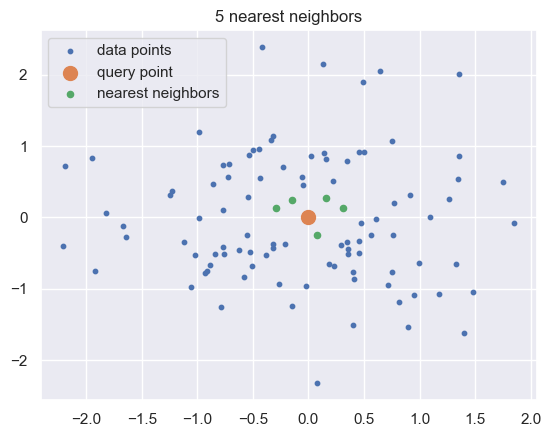

In [3]:
np.random.seed(13)
X=np.random.randn(100,2)
p=np.array([0,0])

k=5
I=kneighbors(X,p,k)
plt.scatter(X[:,0],X[:,1],s=10, label='data points')
plt.scatter(p[0],p[1],s=100, label='query point')
plt.scatter(X[I,0], X[I,1],s=20, label='nearest neighbors')
plt.title(f'{k} nearest neighbors')
plt.legend();

## K-Nearest Neighbors Classifier

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin #to wrap our estimators as sklearn estimators
import warnings
warnings.filterwarnings("ignore")

In [5]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors=n_neighbors
    def fit(self, data, labels):
        self.data=data
        self.labels=labels
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            neighbors = kneighbors(data=self.data,point=X[i],n_neighbors=self.n_neighbors)
            y_pred[i]=stats.mode(self.labels[neighbors])[0][0]
        return y_pred

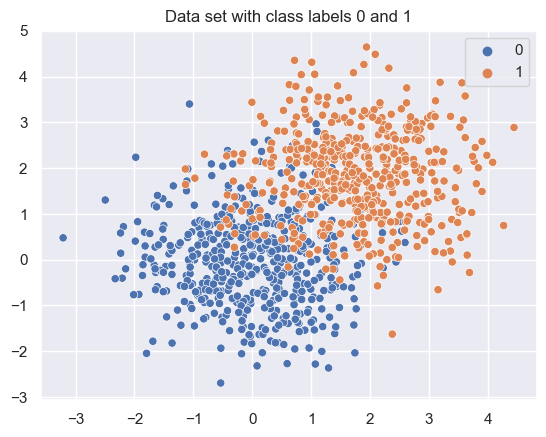

In [6]:
#Create a data set to apply our classifier
np.random.seed(13)
N=500
X = np.concatenate(
    (np.random.randn(N,2), np.random.randn(N,2)+[1.8,1.8]),
    axis=0
)
y = np.concatenate(
    (np.zeros(N), np.ones(N)),
    axis=0
).astype(int)

sns.scatterplot(x=X[:,0],y=X[:,1], hue=y)
plt.title('Data set with class labels 0 and 1');

In [7]:
model = KNNClassifier(n_neighbors=5)
model.fit(X,y)
y_pred = model.predict(X)

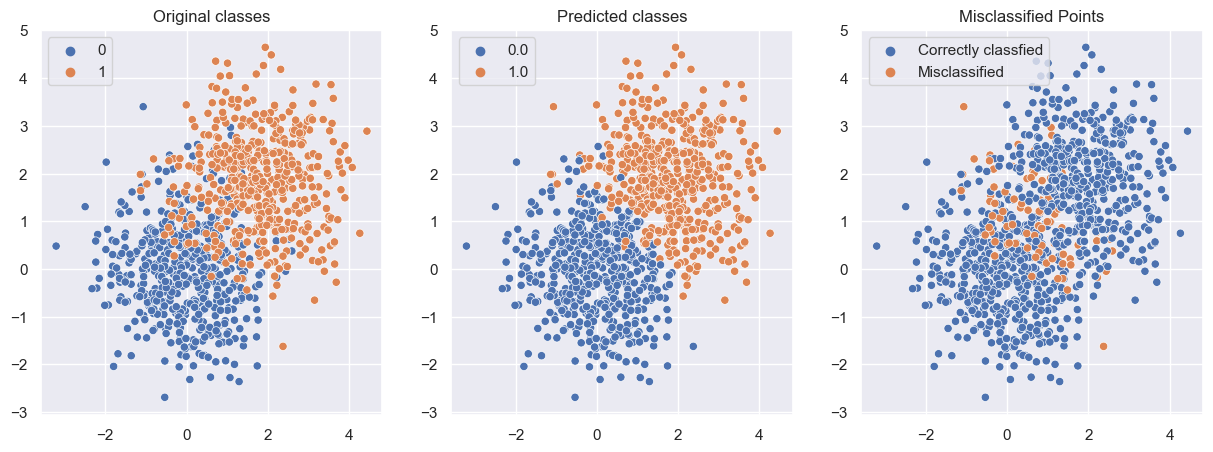

In [8]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.set_title('Original classes')
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y, ax=ax1)
ax2.set_title('Predicted classes')
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y_pred, ax=ax2)
ax3.set_title('Misclassified Points')
z=["Correctly classfied" if a==b else "Misclassified" for a,b in zip(y,y_pred)]
sns.scatterplot(x=X[:,0],y=X[:,1], hue=z);

The following figure shows the predictions of the model on unseen points:

In [9]:
def visualize2dEstimator(data, estimator, delta=0.1):
    xmin, xmax = data[:,0].min() - 1, data[:,0].max() + 1
    ymin, ymax = data[:,1].min() - 1, data[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(xmin,xmax,delta), np.arange(ymin,ymax,delta))
    Z = estimator.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
    plt.pcolormesh(xx,yy,Z,alpha=0.2)

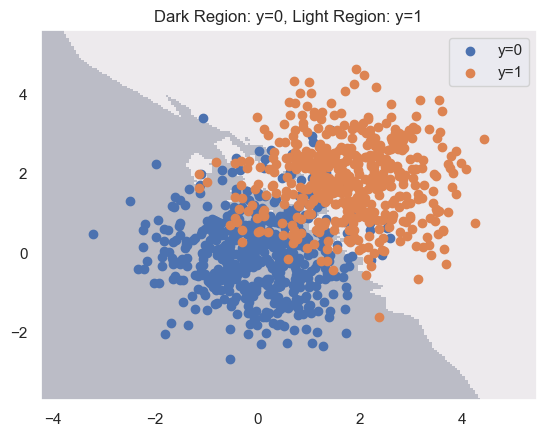

In [10]:
visualize2dEstimator(X,model,delta=0.05)
plt.scatter(X[y==0,0],X[y==0,1],label='y=0')
plt.scatter(X[y==1,0],X[y==1,1],label='y=1');
plt.legend()
plt.title('Dark Region: y=0, Light Region: y=1');

## K-Nearest Neighbors Regressor

In [11]:
class KNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors=n_neighbors
    def fit(self, data, labels):
        self.data=data
        self.labels=labels
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            neighbors = kneighbors(data=self.data,point=X[i],n_neighbors=self.n_neighbors)
            y_pred[i]=self.labels[neighbors].mean()
        return y_pred

In [12]:
np.random.seed(13)
N=100
X = np.random.randn(N)
f = lambda x: (x+2)*(x+1)*x*(x-1)*(x-2)
y = f(X)+ 0.2*np.random.randn(N)

model = KNNRegressor(n_neighbors=5)
model.fit(X,y)
y

sns.scatterplot(x=X,y=y_pred, label='training data', color='red')
xmin, xmax =X.min()-1, X.max()+1
xs = np.arange(xmin,xmax,0.01)
ys = model.predict(xs)
sns.lineplot(xs,ys,label='KNN predicted values')
plt.legend();

ValueError: All arrays must be of the same length